Data Validation and integrity chek

Loading the data

In [3]:
import pandas as pd 
import numpy as np

data = "/Users/tarunshyam/Learning/NASA_Battery_data/Randomized Battery Usage/RW_all_subgroups_parallel_output.csv"

df = pd.read_csv(data)
print(df.shape)
df.head()

(1081851, 7)


,type,relative_time,voltage,current,temperature,source_file,subgroup
0,C,"[0.04, 60.04, 120.04, 180.04, 240.04, 300.04, ...","[3.958, 4.03, 4.048, 4.056, 4.061, 4.065, 4.07...","[-2.008, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -...","[22.54026, 22.58708, 22.71192, 22.91478, 23.11...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
1,R,"[0.01, 60.01, 120.01, 180.01, 240.01, 300.0]","[4.199, 4.199, 4.198, 4.198, 4.198, 4.198]","[0, 0, 0, 0, 0, 0]","[21.85364, 21.86925, 21.86925, 21.85364, 21.83...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
2,D,"[0.04, 30.04, 60.04, 90.03999999999999, 120.04...","[4.115, 4.087, 4.071, 4.061, 4.053, 4.046, 4.0...","[1.004, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 0.999,...","[21.85364, 21.90046, 21.94728, 21.99409, 22.04...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
3,R,"[0.01, 60.01, 120.01, 180.01, 240.01, 300.01, ...","[3.275, 3.371, 3.384, 3.39, 3.394, 3.397, 3.39...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[26.05137, 25.95774, 25.75488, 25.55201, 25.33...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
4,C,"[0.04, 60.04, 120.04, 180.04, 240.04, 300.04, ...","[3.633, 3.83, 3.912, 3.93, 3.936, 3.944, 3.954...","[-2.005, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -...","[25.38036, 25.39596, 25.89532, 25.64564, 26.87...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post


In [4]:
import ast

In [5]:
df = pd.read_csv(data)

# Basic structure
print(df.columns)
print(df.dtypes)

Index(['type', 'relative_time', 'voltage', 'current', 'temperature',
       'source_file', 'subgroup'],
      dtype='object')
type             object
relative_time    object
voltage          object
current          object
temperature      object
source_file      object
subgroup         object
dtype: object


In [6]:
def is_valid_list(column):
    try:
        return isinstance(ast.literal_eval(column), list)
    except:
        return False

for col in ['relative_time', 'voltage', 'current', 'temperature']:
    df[f'{col}_valid'] = df[col].apply(is_valid_list)
    print(f"{col}: {df[f'{col}_valid'].sum()} valid out of {len(df)}")

relative_time: 1081851 valid out of 1081851
voltage: 1081851 valid out of 1081851
current: 1081851 valid out of 1081851
temperature: 1081851 valid out of 1081851


Check Time-Series Length Consistency Per Row


In [7]:
def check_consistency(row):
    try:
        rt = ast.literal_eval(row['relative_time'])
        v = ast.literal_eval(row['voltage'])
        c = ast.literal_eval(row['current'])
        t = ast.literal_eval(row['temperature'])
        return len(rt) == len(v) == len(c) == len(t)
    except:
        return False

df['lengths_consistent'] = df.apply(check_consistency, axis=1)
print("Consistent rows:", df['lengths_consistent'].sum())


Consistent rows: 1081851


In [8]:
def has_physical_outliers(row):
    try:
        v = ast.literal_eval(row['voltage'])
        t = ast.literal_eval(row['temperature'])
        c = ast.literal_eval(row['current'])
        return any(val < 0 for val in v) or any(abs(val) > 10 for val in c) or any(ti < -40 or ti > 100 for ti in t)
    except:
        return True

df['has_outliers'] = df.apply(has_physical_outliers, axis=1)
print("Rows with physical outliers:", df['has_outliers'].sum())


Rows with physical outliers: 29712


In [9]:
df_clean = df[df['lengths_consistent'] & ~df['has_outliers']]

In [10]:
df_long = df_clean.explode(['relative_time', 'voltage', 'current', 'temperature']).reset_index(drop=True)

In [11]:
df_clean.head()

,type,relative_time,voltage,current,temperature,source_file,subgroup,relative_time_valid,voltage_valid,current_valid,temperature_valid,lengths_consistent,has_outliers
0,C,"[0.04, 60.04, 120.04, 180.04, 240.04, 300.04, ...","[3.958, 4.03, 4.048, 4.056, 4.061, 4.065, 4.07...","[-2.008, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -...","[22.54026, 22.58708, 22.71192, 22.91478, 23.11...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,True,True,True,True,True,False
1,R,"[0.01, 60.01, 120.01, 180.01, 240.01, 300.0]","[4.199, 4.199, 4.198, 4.198, 4.198, 4.198]","[0, 0, 0, 0, 0, 0]","[21.85364, 21.86925, 21.86925, 21.85364, 21.83...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,True,True,True,True,True,False
2,D,"[0.04, 30.04, 60.04, 90.03999999999999, 120.04...","[4.115, 4.087, 4.071, 4.061, 4.053, 4.046, 4.0...","[1.004, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 0.999,...","[21.85364, 21.90046, 21.94728, 21.99409, 22.04...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,True,True,True,True,True,False
3,R,"[0.01, 60.01, 120.01, 180.01, 240.01, 300.01, ...","[3.275, 3.371, 3.384, 3.39, 3.394, 3.397, 3.39...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[26.05137, 25.95774, 25.75488, 25.55201, 25.33...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,True,True,True,True,True,False
4,C,"[0.04, 60.04, 120.04, 180.04, 240.04, 300.04, ...","[3.633, 3.83, 3.912, 3.93, 3.936, 3.944, 3.954...","[-2.005, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -...","[25.38036, 25.39596, 25.89532, 25.64564, 26.87...",RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,True,True,True,True,True,False


Transforming the Data into flate file

In [13]:
import pandas as pd
import ast

def flatten_dataframe(df):
    records = []

    for _, row in df.iterrows():
        # Ensure lists are really lists, not strings
        time_list = ast.literal_eval(row['relative_time']) if isinstance(row['relative_time'], str) else row['relative_time']
        volt_list = ast.literal_eval(row['voltage']) if isinstance(row['voltage'], str) else row['voltage']
        curr_list = ast.literal_eval(row['current']) if isinstance(row['current'], str) else row['current']
        temp_list = ast.literal_eval(row['temperature']) if isinstance(row['temperature'], str) else row['temperature']

        n = min(len(time_list), len(volt_list), len(curr_list), len(temp_list))  # safeguard

        for i in range(n):
            records.append({
                'type': row['type'],
                'source_file': row['source_file'],
                'subgroup': row['subgroup'],
                'sample_index': i,
                'relative_time': time_list[i],
                'voltage': volt_list[i],
                'current': curr_list[i],
                'temperature': temp_list[i]
            })

    return pd.DataFrame(records)

# Example usage:
df_flat = flatten_dataframe(df_clean)
print("Flattened shape:", df_flat.shape)
df_flat.to_csv("flattened_battery_data.csv", index=False)


Flattened shape: (72501389, 8)


In [15]:
df_flat.head(20)

,type,source_file,subgroup,sample_index,relative_time,voltage,current,temperature
0,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,0,0.04,3.958,-2.008,22.54026
1,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,1,60.04,4.030,-2.000,22.58708
2,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,2,120.04,4.048,-2.000,22.71192
3,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,3,180.04,4.056,-2.000,22.91478
4,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,4,240.04,4.061,-2.000,23.11764
5,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,5,300.04,4.065,-2.000,23.35172
6,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,6,360.04,4.070,-2.000,23.57019
7,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,7,420.04,4.075,-2.001,23.78865
8,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,8,480.04,4.081,-2.000,23.94470
9,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,9,540.04,4.086,-2.000,24.14757


General info

In [16]:
print("Dataset Shape:", df_flat.shape)
print("\nData Types:\n", df_flat.dtypes)

Dataset Shape: (72501389, 8)

Data Types:
 type              object
source_file       object
subgroup          object
sample_index       int64
relative_time    float64
voltage          float64
current          float64
temperature      float64
dtype: object


In [17]:
# 2. Check for missing values
print("\nMissing values per column:\n", df_flat.isnull().sum())


Missing values per column:
 type             0
source_file      0
subgroup         0
sample_index     0
relative_time    0
voltage          0
current          0
temperature      0
dtype: int64


In [18]:
# 3. Describe numerical features
print("\nSummary statistics:\n", df_flat[['relative_time', 'voltage', 'current', 'temperature']].describe())



Summary statistics:
        relative_time       voltage       current   temperature
count   7.250139e+07  7.250139e+07  7.250139e+07  7.250139e+07
mean    1.352807e+03  3.737206e+00  7.934986e-01  3.057838e+01
std     8.661932e+03  2.962744e-01  1.809391e+00  7.454705e+00
min     1.000000e-02  2.715000e+00 -4.614000e+00 -3.961133e+01
25%     3.804000e+01  3.493000e+00 -3.060000e-01  2.477269e+01
50%     1.200400e+02  3.714000e+00  7.500000e-01  2.939387e+01
75%     2.610400e+02  3.991000e+00  2.000000e+00  3.502134e+01
max     1.912716e+05  4.624000e+00  5.117000e+00  5.978934e+01


In [19]:

# 4. Check for negative or unrealistic values
print("\nNegative or zero voltages:", (df_flat['voltage'] <= 0).sum())
print("Negative or zero current values:", (df_flat['current'] <= 0).sum())
print("Extremely high temperatures (>100°C):", (df_flat['temperature'] > 100).sum())
print("Negative temperatures:", (df_flat['temperature'] < 0).sum())


Negative or zero voltages: 0
Negative or zero current values: 29550653
Extremely high temperatures (>100°C): 0
Negative temperatures: 3686


In [20]:
# 5. Check if type labels are consistent
print("\nType value counts:\n", df_flat['type'].value_counts())


Type value counts:
 type
D    42950745
C    23330957
R     6219687
Name: count, dtype: int64


In [21]:
# 6. Preview first few rows
print("\nPreview:\n", df_flat.head())


Preview:
   type source_file                                subgroup  sample_index  \
0    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post             0   
1    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post             1   
2    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post             2   
3    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post             3   
4    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post             4   

   relative_time  voltage  current  temperature  
0           0.04    3.958   -2.008     22.54026  
1          60.04    4.030   -2.000     22.58708  
2         120.04    4.048   -2.000     22.71192  
3         180.04    4.056   -2.000     22.91478  
4         240.04    4.061   -2.000     23.11764  


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

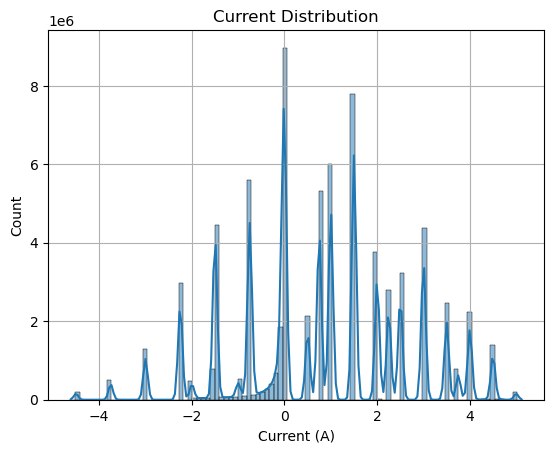

In [23]:

# Plot current distribution
sns.histplot(df_flat['current'], bins=100, kde=True)
plt.title('Current Distribution')
plt.xlabel('Current (A)')
plt.ylabel('Count')
plt.grid(True)
plt.show()



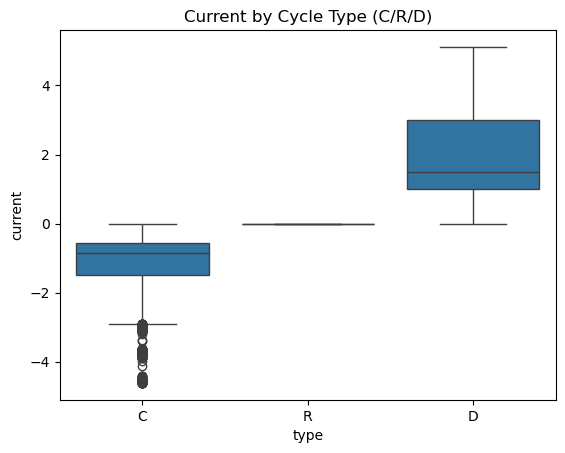

In [24]:
# Boxplot of current per type
sns.boxplot(x='type', y='current', data=df_flat)
plt.title('Current by Cycle Type (C/R/D)')
plt.show()


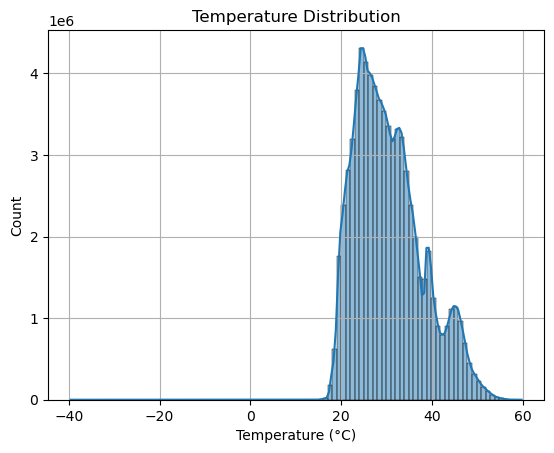

In [25]:
# Temperature distribution
sns.histplot(df_flat['temperature'], bins=100, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [26]:
df_vector = pd.read_csv("/Users/tarunshyam/Learning/NASA_Battery_data/Randomized Battery Usage/ETL/Transformation/battery_data_vectorized.csv")

In [27]:
print("Top rows:\n", df_vector.head())

Top rows:
   type source_file                                subgroup  time_mean  \
0    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post        NaN   
1    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post        NaN   
2    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post        NaN   
3    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post        NaN   
4    C    RW17.mat  RW_Skewed_High_Room_Temp_DataSet_2Post        NaN   

   time_std  time_min  time_max  volt_mean  volt_std  volt_min  volt_max  \
0       NaN       NaN       NaN        NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN        NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN        NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN        NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN        NaN       NaN       NaN       NaN   

   curr_mean  curr_std  curr_min  curr_max  temp_mean  temp_std  temp_min  \
0        NaN    

In [28]:
print("\nColumn types:\n", df_vector.dtypes)


Column types:
 type            object
source_file     object
subgroup        object
time_mean      float64
time_std       float64
time_min       float64
time_max       float64
volt_mean      float64
volt_std       float64
volt_min       float64
volt_max       float64
curr_mean      float64
curr_std       float64
curr_min       float64
curr_max       float64
temp_mean      float64
temp_std       float64
temp_min       float64
temp_max       float64
dtype: object


In [29]:
df = pd.read_csv("/Users/tarunshyam/Learning/NASA_Battery_data/Randomized Battery Usage/flattened_battery_data.csv")

# Let's inspect a row that should contain array data
sample_row = df.iloc[0]
print("Sample 'relative_time' type:", type(sample_row['relative_time']))
print("Sample value:", sample_row['relative_time'])

Sample 'relative_time' type: <class 'numpy.float64'>
Sample value: 0.04


In [30]:
df_flat.head(20)

,type,source_file,subgroup,sample_index,relative_time,voltage,current,temperature
0,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,0,0.04,3.958,-2.008,22.54026
1,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,1,60.04,4.030,-2.000,22.58708
2,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,2,120.04,4.048,-2.000,22.71192
3,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,3,180.04,4.056,-2.000,22.91478
4,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,4,240.04,4.061,-2.000,23.11764
5,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,5,300.04,4.065,-2.000,23.35172
6,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,6,360.04,4.070,-2.000,23.57019
7,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,7,420.04,4.075,-2.001,23.78865
8,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,8,480.04,4.081,-2.000,23.94470
9,C,RW17.mat,RW_Skewed_High_Room_Temp_DataSet_2Post,9,540.04,4.086,-2.000,24.14757


In [32]:
print(df_flat.columns.to_list())


['type', 'source_file', 'subgroup', 'sample_index', 'relative_time', 'voltage', 'current', 'temperature']


In [33]:
# Basic overview
print("Data shape:", df_flat.shape)
print("\nData types:\n", df_flat.dtypes)
print("\nMissing values:\n", df_flat.isnull().sum())

Data shape: (72501389, 8)

Data types:
 type              object
source_file       object
subgroup          object
sample_index       int64
relative_time    float64
voltage          float64
current          float64
temperature      float64
dtype: object

Missing values:
 type             0
source_file      0
subgroup         0
sample_index     0
relative_time    0
voltage          0
current          0
temperature      0
dtype: int64


In [ ]:
#Summary Statistics
print("\nData types:\n",df_flat.describe)


Data types:
 <bound method NDFrame.describe of          type source_file                                           subgroup  \
0           C    RW17.mat             RW_Skewed_High_Room_Temp_DataSet_2Post   
1           C    RW17.mat             RW_Skewed_High_Room_Temp_DataSet_2Post   
2           C    RW17.mat             RW_Skewed_High_Room_Temp_DataSet_2Post   
3           C    RW17.mat             RW_Skewed_High_Room_Temp_DataSet_2Post   
4           C    RW17.mat             RW_Skewed_High_Room_Temp_DataSet_2Post   
...       ...         ...                                                ...   
72501384    R     RW9.mat  Battery_Uniform_Distribution_Charge_Discharge_...   
72501385    R     RW9.mat  Battery_Uniform_Distribution_Charge_Discharge_...   
72501386    R     RW9.mat  Battery_Uniform_Distribution_Charge_Discharge_...   
72501387    R     RW9.mat  Battery_Uniform_Distribution_Charge_Discharge_...   
72501388    R     RW9.mat  Battery_Uniform_Distribution_Charge_Discharge

In [35]:
# type Distribution
print("\nType distribution:\n", df_flat['type'].value_counts())



Type distribution:
 type
D    42950745
C    23330957
R     6219687
Name: count, dtype: int64


In [36]:
# Subgroup distribution
print("\nSubgroup distribution:\n", df_flat['subgroup'].value_counts())


Subgroup distribution:
 subgroup
Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post             34396993
Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post     8865859
Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post           8165781
RW_Skewed_Low_Room_Temp_DataSet_2Post                                    7143828
RW_Skewed_Low_40C_DataSet_2Post                                          5768106
RW_Skewed_High_Room_Temp_DataSet_2Post                                   4924636
RW_Skewed_High_40C_DataSet_2Post                                         3236186
Name: count, dtype: int64


In [37]:
# Plot distributions
numerical_cols = ['relative_time', 'voltage', 'current', 'temperature']

In [38]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_flat[col], bins=100, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(f'eda_{col}_distribution.png')
    plt.close()

In [40]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_flat[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig('eda_correlation_heatmap.png')
plt.close()


In [39]:
# Time series plot sample for voltage (first 5000 Discharge rows)
sample = df_flat[df_flat['type'] == 'D'].head(5000)
plt.figure(figsize=(10, 4))
sns.lineplot(x='sample_index', y='voltage', data=sample)
plt.title("Voltage vs. Sample Index (Discharge - First 5000 Rows)")
plt.tight_layout()
plt.savefig('eda_voltage_timeseries_sample.png')
plt.close()

Standardization

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
flat
df_flat.head()

NameError: name 'df_flat' is not defined